In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anti-uav-yolo-1024/valid/labels/01028.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01484.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00588.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00286.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00080.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01279.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00440.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02557.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01936.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00733.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00134.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01466.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00709.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/00372.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01850.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02017.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/02363.txt
/kaggle/input/anti-uav-yolo-1024/valid/labels/01

In [2]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2

In [3]:
from sklearn import preprocessing


import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import glob
import cv2
from PIL import Image

In [4]:
BASE_PATH = "/kaggle/input/anti-uav-yolo-1024/train"
TXT_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/labels/*.txt")
IMG_PATH = glob.glob("/kaggle/input/anti-uav-yolo-1024/train/images/*.jpg")
IMG_PATH2 = glob.glob("/kaggle/input/anti-uav-yolo-1024/valid/images/*.jpg")

In [5]:
def convert_format(box, iwidth=300, iheight=300):
    x_center, y_center, width, height = box
    
    x_min = int((x_center - width / 2) * iwidth)
    y_min = int((y_center - height / 2) * iheight)
    x_max = int((x_center + width / 2) * iwidth)
    y_max = int((y_center + height / 2) * iheight)
    
    return [x_min, y_min, x_max, y_max]

In [6]:
import os
from PIL import Image

train_image = []
train_image_path = []
train_image_id = []
train_annotation = []

for img_path in IMG_PATH:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
   

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/train/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((300, 300))
            train_image.append(np.asarray(nmpy_img))
            train_image_path.append(img_path)
            train_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                train_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")


Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00639.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00724.jpg
Annotation file is empty for image: /kaggle/input/anti-uav-yolo-1024/train/images/00579.jpg
Images and annotations processed successfully.


In [7]:

valid_image = []
valid_image_path = []
valid_image_id = []
valid_annotation = []

for img_path in IMG_PATH2:
    # Extract image ID
    image_id = os.path.basename(img_path).split('.')[0]
    

    # Construct path for annotation file
    annotation_path = os.path.join("/kaggle/input/anti-uav-yolo-1024/valid/labels/", image_id + ".txt")

    # Check if annotation file exists
    if os.path.exists(annotation_path):
        # Check if annotation file is not empty
        if os.path.getsize(annotation_path) > 0:
            Load_image = Image.open(img_path).convert('RGB')
            nmpy_img = Load_image.resize((300, 300))
            valid_image.append(np.asarray(nmpy_img))
            valid_image_path.append(img_path)
            valid_image_id.append(image_id)

            # Read annotation file
            with open(annotation_path) as f:
                lines = f.readlines()
                tmp_lst = lines[0].split(' ')
                startX = float(tmp_lst[1])
                startY = float(tmp_lst[2])
                endX = float(tmp_lst[3])
                endY = float(tmp_lst[4])

                valid_annotation.append(convert_format([startX, startY, endX, endY]))
        else:
            print(f"Annotation file is empty for image: {img_path}")
    else:
        print(f"Annotation file not found for image: {img_path}")

print("Images and annotations processed successfully.")

Images and annotations processed successfully.


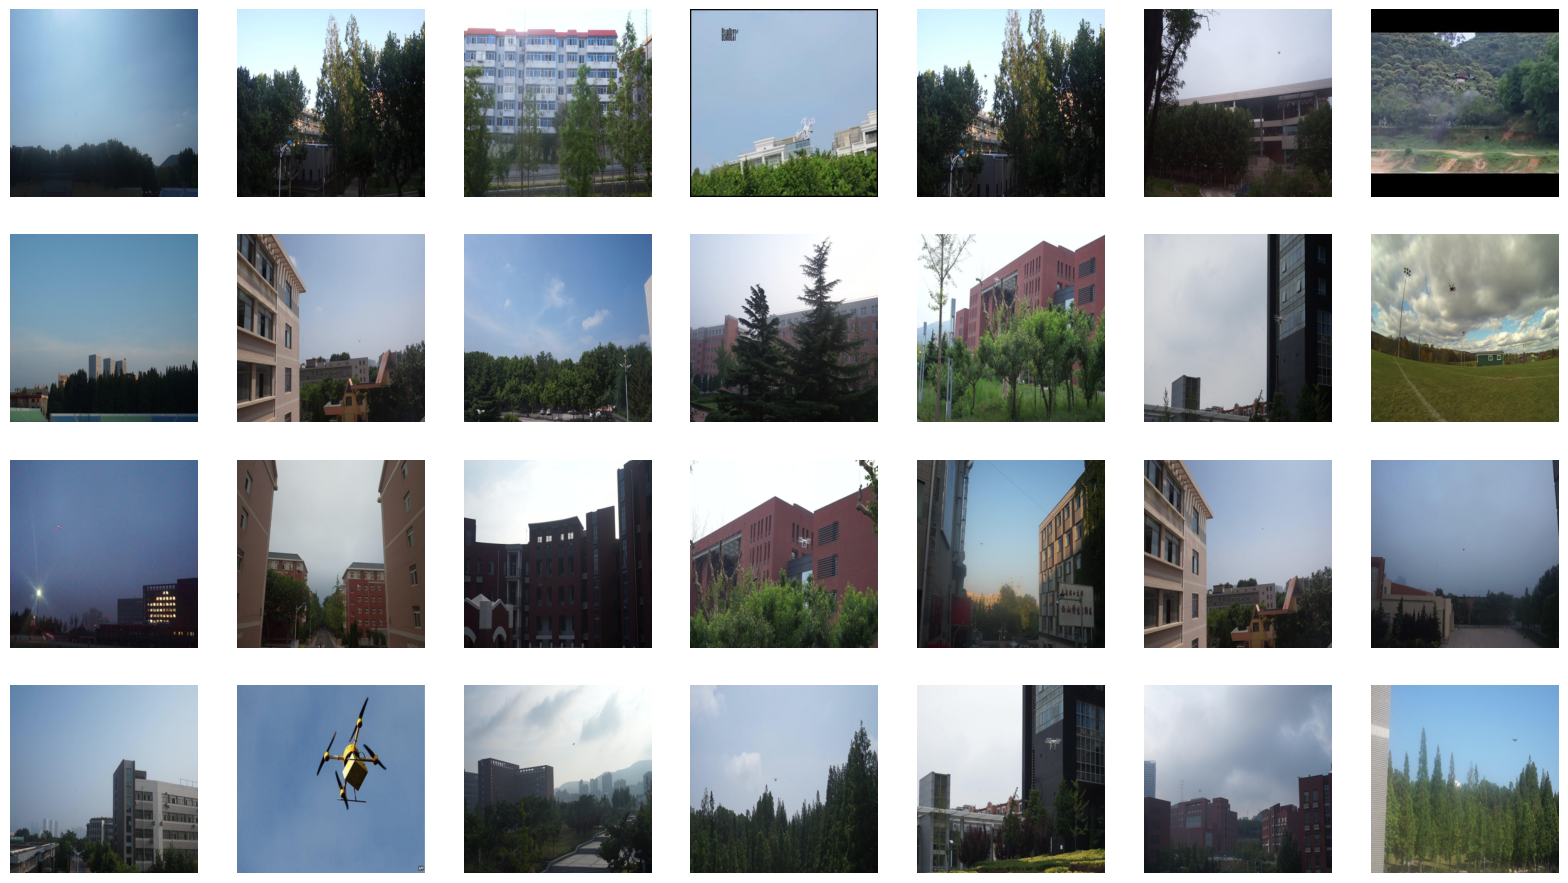

In [8]:
plt.figure(figsize=(20, 20))

for i in range(28):
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(train_image[i].astype("uint8"))
    plt.axis("off")

In [9]:
df = pd.DataFrame()
df['boxes'] = train_annotation
df['img_path'] = train_image_path
df['labels'] = 'drone'
df['img_id'] = train_image_id

In [10]:
df2 = pd.DataFrame()
df2['boxes'] = valid_annotation
df2['img_path'] = valid_image_path
df2['labels'] = 'drone'
df2['img_id'] = valid_image_id

In [11]:
df2

boxes                                           img_path  \
0       [36, 194, 45, 200]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
1     [192, 163, 198, 166]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
2     [235, 155, 242, 161]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
3     [103, 166, 210, 210]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
4     [213, 111, 219, 117]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
...                    ...                                                ...   
2595    [134, 76, 157, 90]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
2596    [127, 36, 131, 42]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
2597  [153, 170, 157, 175]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
2598   [78, 109, 101, 127]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   
2599  [178, 125, 191, 143]  /kaggle/input/anti-uav-yolo-1024/valid/images/...   

     labels img_id  
0     drone  02371  
1     drone  00767  
2     drone  02360  
3     drone  00266  
4     drone  02450  
...     ...    ...  
2595  drone  00319  
2596  drone  01863  
2597  drone  01325  
2598  drone  00222  
2599  drone  00117  

[2600 rows x 4 columns]

In [12]:
df

boxes                                           img_path  \
0     [165, 206, 170, 209]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
1       [86, 105, 93, 112]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
2     [137, 111, 140, 114]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
3     [168, 174, 199, 210]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
4     [105, 103, 113, 111]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
...                    ...                                                ...   
5192  [143, 179, 147, 185]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
5193  [147, 180, 152, 184]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
5194    [46, 208, 55, 216]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
5195    [18, 150, 23, 152]  /kaggle/input/anti-uav-yolo-1024/train/images/...   
5196   [50, 154, 183, 256]  /kaggle/input/anti-uav-yolo-1024/train/images/...   

     labels img_id  
0     drone  04168  
1     drone  02371  
2     drone  04377  
3     drone  00767  
4     drone  02360  
...     ...    ...  
5192  drone  02956  
5193  drone  04731  
5194  drone  03358  
5195  drone  04801  
5196  drone  00117  

[5197 rows x 4 columns]

In [13]:
import numpy as np
from sklearn import preprocessing

enc = preprocessing.LabelEncoder()
df['labels'] = enc.fit_transform(df['labels'])
df['labels'] = np.stack([df['labels'][i]+1 for i in range(len(df['labels']))])

df2['labels'] = enc.fit_transform(df2['labels'])
df2['labels'] = np.stack([df2['labels'][i]+1 for i in range(len(df2['labels']))])

In [14]:
import numpy as np

# Assuming df['boxes'] contains arrays/lists of coordinates
# Create separate columns for 'xmin', 'ymin', 'xmax', 'ymax'
df[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df.drop(columns=['boxes'], inplace=True)
df['xmin'] = df['xmin'].astype(float)
df['ymin'] = df['ymin'].astype(float)
df['xmax'] = df['xmax'].astype(float)
df['ymax'] = df['ymax'].astype(float)

df2[['xmin', 'ymin', 'xmax', 'ymax']] = np.stack(df2['boxes'].apply(lambda x: np.array(x)).values)

# Drop the 'boxes' column
df2.drop(columns=['boxes'], inplace=True)
df2['xmin'] = df2['xmin'].astype(float)
df2['ymin'] = df2['ymin'].astype(float)
df2['xmax'] = df2['xmax'].astype(float)
df2['ymax'] = df2['ymax'].astype(float)

In [15]:
df_removed_damaged1 = df.drop(df[(df.ymin >= df.ymax) | (df.xmin >= df.xmax)].index)
df_removed_damaged1

mask = (df['ymin'] >= 300) | (df['ymax'] >= 300) | (df['xmin'] >= 300) | (df['xmax'] >= 300)
# Drop rows where the condition is True
df_removed_damaged = df_removed_damaged1.drop(df[mask].index)

df2_removed_damaged1 = df2.drop(df2[(df2.ymin >= df2.ymax) | (df2.xmin >= df2.xmax)].index)
df2_removed_damaged1

mask = (df2['ymin'] >= 300) | (df2['ymax'] >= 300) | (df2['xmin'] >= 300) | (df2['xmax'] >= 300)
# Drop rows where the condition is True
df2_removed_damaged = df2_removed_damaged1.drop(df2[mask].index)

In [16]:
train_ds=df_removed_damaged
val_ds=df2_removed_damaged
val_ds

img_path  labels img_id   xmin  \
0     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  02371   36.0   
1     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00767  192.0   
2     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  02360  235.0   
3     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00266  103.0   
4     /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  02450  213.0   
...                                                 ...     ...    ...    ...   
2595  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00319  134.0   
2596  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01863  127.0   
2597  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  01325  153.0   
2598  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00222   78.0   
2599  /kaggle/input/anti-uav-yolo-1024/valid/images/...       1  00117  178.0   

       ymin   xmax   ymax  
0     194.0   45.0  200.0  
1     163.0  198.0  166.0  
2     155.0  242.0  161.0  
3     166.0  210.0  210.0  
4     111.0  219.0  117.0  
...     ...    ...    ...  
2595   76.0  157.0   90.0  
2596   36.0  131.0   42.0  
2597  170.0  157.0  175.0  
2598  109.0  101.0  127.0  
2599  125.0  191.0  143.0  

[2592 rows x 7 columns]

In [39]:
class TrainDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.resize(image, (300, 300))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]

        boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values

        if len(boxes) == 0:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'image_id': torch.tensor([index]),
                'area': torch.zeros(0, dtype=torch.float32),
                'iscrowd': torch.zeros(0, dtype=torch.int64)
            }
        else:

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            label = records['labels'].values
            labels = torch.as_tensor(label, dtype=torch.int64)

            # Suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([index]),
                'area': area,
                'iscrowd': iscrowd
            }

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

            # Only stack the boxes if there are non-empty bounding boxes
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [42]:
def get_transform_train():
    return A.Compose([
        #A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        #A.LongestMaxSize(max_size=300, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [43]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = TrainDataset(train_ds, '/kaggle/input/anti-uav-yolo-1024/train/images', get_transform_train())
valid_dataset = TrainDataset(val_ds, '/kaggle/input/anti-uav-yolo-1024/valid/images', get_transform_train())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [56]:
images,targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
#targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]

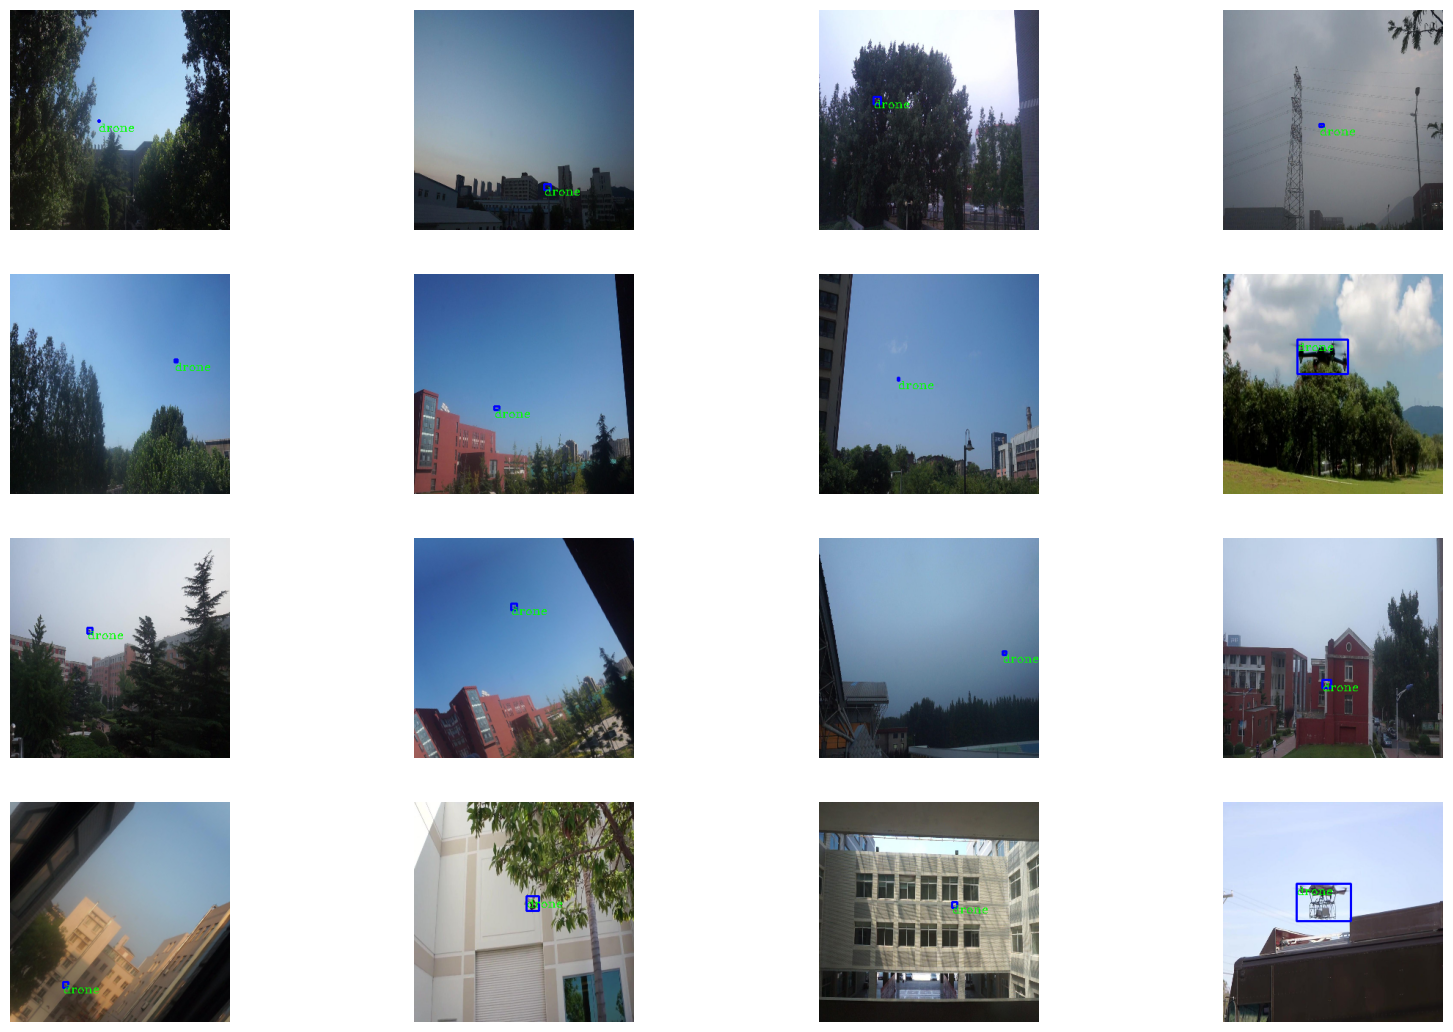

In [57]:
classes= {1:'drone'}

plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(6,4, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy() * 255
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 0, 220), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)

    plt.axis('off')
    plt.imshow(sample)

In [46]:
for i, (image, target) in enumerate(zip(images, targets)):
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    for i,box in enumerate(boxes):
        print(box[0], box[1],box[2], box[3])

101 193 102 196
169 93 176 100
226 127 240 139
146 128 150 131
24 56 266 230
219 80 232 89
133 244 136 249
166 265 175 271
65 136 98 160
131 47 177 95
196 176 201 180
4 170 8 174
149 148 152 150
120 93 127 98
54 179 58 182
111 156 123 167


In [24]:
!pip install pycocotools
! pip install -U ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 7.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6080 sha256=d14007698b0ccbe3cb7fd1e602a31aadd20d851d1402ff2c871af265919c3291
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [26]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
num_classes=2

in_channels=det_utils.retrieve_out_channels(model.backbone,(300,300))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 167MB/s]  


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [27]:
for params in model.backbone.features.parameters():
    params.requires_grad=False
    
parameters=[params for params in model.parameters() if params.requires_grad]

learning_rate=3e-5
optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, 
                                                  patience=7, threshold=0.0001)

In [28]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [58]:
"""Model has been trained and its weights are stored in pothole-detection-learned-weights,
if you want to train it yourself uncomment the below code, it takes around 50 minutes."""

epochs=20
loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_data_loader.dataset)
val_len=len(valid_data_loader.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    validation_loss=0.0
    
    current_lr=get_lr(optimizer)
    
    #During training, the model expects both the input tensors, as well as a targets 
    model.train()
    for imgs,targets in train_data_loader:
        imgs=[img.to(device) for img in imgs]
        #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        #targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        
        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    with torch.no_grad():
        for imgs,targets in valid_data_loader:
            imgs=[img.to(device) for img in imgs]
            #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
            #targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
            targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
           
            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

#torch.save(best_weights,model_weights_file)

Updating Best Model weights

1/20
Training Loss: 0.4613329886867085
Validation_loss: 0.9526277646157271

**************************************************
Updating Best Model weights

2/20
Training Loss: 0.4449033876186806
Validation_loss: 0.9144562398631073

**************************************************
Updating Best Model weights

3/20
Training Loss: 0.4234304817071829
Validation_loss: 0.8843224284736285

**************************************************
Updating Best Model weights

4/20
Training Loss: 0.4135793199550063
Validation_loss: 0.8625711060752513

**************************************************
Updating Best Model weights

5/20
Training Loss: 0.4045552846454793
Validation_loss: 0.8540936675003176

**************************************************
Updating Best Model weights

6/20
Training Loss: 0.39110048328630587
Validation_loss: 0.8252235753294088

**************************************************
Updating Best Model weights

7/20
Training Loss: 0.393209846840

In [59]:
loss_history

{'training_loss': [0.4613329886867085,
  0.4449033876186806,
  0.4234304817071829,
  0.4135793199550063,
  0.4045552846454793,
  0.39110048328630587,
  0.39320984684040206,
  0.3850233348981987,
  0.3809114574409541,
  0.38321445745547694,
  0.3801844362537761,
  0.3791662967211266,
  0.37765423549366767,
  0.3787245239889338,
  0.3729515377933541,
  0.37291366541736415,
  0.37487282770173436,
  0.36694035405004055,
  0.3714792657607668,
  0.3665768376538309],
 'validation_loss': [0.9526277646157271,
  0.9144562398631073,
  0.8843224284736285,
  0.8625711060752513,
  0.8540936675003176,
  0.8252235753294088,
  0.8192393351015578,
  0.8134533092103815,
  0.8115292407989926,
  0.8076957963481849,
  0.8058234717266324,
  0.7995591690699343,
  0.8102324555431567,
  0.8002963319522433,
  0.7990589047103821,
  0.799070930994039,
  0.7879917295843952,
  0.8003541199731775,
  0.8052543318772395,
  0.7945984330861773]}

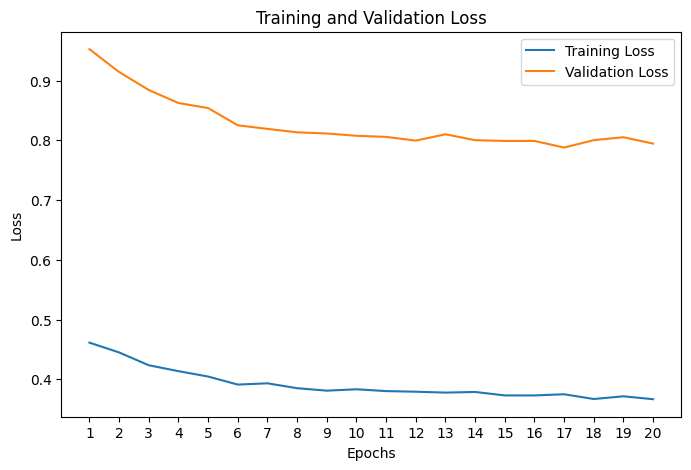

In [85]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1),loss_history["training_loss"], label='Training Loss')
plt.plot(range(1, epochs+1), loss_history["validation_loss"], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xticks(range(1, epochs+1))
plt.legend()
#plt.grid(True)
plt.show()

In [93]:
from torchmetrics.detection import MeanAveragePrecision
metric=MeanAveragePrecision(box_format='xyxy',class_metrics=True)
metric.to(device)

MeanAveragePrecision()

In [105]:
MeanAveragePrecision()
threshold=0.25
iou_threshold=0.75
def preprocess_bbox(prediction):
    
    """Non-max suppression is the final step of these object detection algorithms and is 
       used to select the most appropriate bounding box for the object.
       The NMS takes two things into account
        -The objectiveness score is given by the model
        -The overlap or IOU of the bounding boxes"""
    
    processed_bbox={}
    
    boxes=prediction["boxes"][prediction["scores"]>=threshold]
    scores=prediction["scores"][prediction["scores"]>=threshold]
    labels=prediction["labels"][prediction["scores"]>=threshold]
    nms=torchvision.ops.nms(boxes,scores,iou_threshold=iou_threshold)
            
    processed_bbox["boxes"]=boxes[nms]
    processed_bbox["scores"]=scores[nms]
    processed_bbox["labels"]=labels[nms]
    
    return processed_bbox

In [106]:
model.eval()
with torch.no_grad():
    for imgs,targets in valid_data_loader:
        imgs=[img.to(device) for img in imgs]
        #targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]
        targets = [{k: torch.as_tensor(v).detach().to(device) for k, v in t.items()} for t in targets]
        predictions=model(imgs)
        
        results=[]
        for prediction in predictions:
            results.append(preprocess_bbox(prediction))
            #results.append(prediction)
        metric.update(results,targets)
results=metric.compute()

In [107]:
ssd_mean_ap=results["map"].item()
ssd_mean_ap_50=results["map_50"].item()
ssd_mean_ap_75=results["map_75"].item()

print(f"Mean Average Precision[0.5:0.95:0.05] : {ssd_mean_ap:.4f}")
print(f"Mean Average Precision @ 0.5          : {ssd_mean_ap_50:.4f}")
print(f"Mean Average Precision @ 0.75         : {ssd_mean_ap_75:.4f}")

Mean Average Precision[0.5:0.95:0.05] : 0.1842
Mean Average Precision @ 0.5          : 0.4077
Mean Average Precision @ 0.75         : 0.1224


In [108]:
import json

# Save loss_history dictionary to a JSON file
with open('loss_history.json', 'w') as json_file:
    json.dump(loss_history, json_file)

In [109]:
torch.save(model.state_dict(), 'ssdmodeldict.pth')

In [110]:
torch.save(model, 'ssdentire_model.pth')